In [10]:
import numpy as np
from obspy import read
from obspy.io.xseed import Parser
from obspy.imaging.spectrogram import _nearest_pow_2
from scipy import signal
import obspy
import matplotlib.pyplot as plt
from IPython.display import Image

from matplotlib import mlab, transforms
plt.rcParams['image.cmap'] = 'inferno'
import math as M
import matplotlib as mpl
import numpy.ma as ma
import time as time

from func.def_master import hps_algo

## Set Parameter for Station, Date, Filters

In [11]:
station = 'KNR02' ## Station
components = ['BH2']
#components = ['BHZ', 'BH1', 'BH2', 'BDH']## Component
#components = ['BHZ']
year = 2016
#day = '065'
startday = '300'
year= str(year)
decimate_factor = 10
pre_filt=(.001,.005,12,15) ## Parameter for filtering during response remove
#pre_filt=(.005,.006,10,12) ## Parameter for filtering during response remove
data_decimate_factor = 2
freq_min_bandpass = .9 ## filtercorners for filtering after response remove
freq_max_bandpass = 2.5 ## filtercorners for filtering after response remove
#per_lap = .9


In [ ]:
## original to calculate with gaps inbetween days
#start_day = str(day)

year = str(year)

number_of_days = 15

threshold = -10
threshold = 10**(threshold)



#per_lap = .1




freq_minimal_value = 3
distance = 120
maxima= 1
decimate_factor = 1e-15

for j in range(len(components)):
    day = startday
    for i in range(number_of_days):
        print(day)
        ## Depends on workstation 
        #st_BHZ = read('../../2016/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + start_day)
        trace = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + day)
        #parser01_BHZ = Parser('../../TEST_DATA/Resp/RESP.1B.' + station + '..' + component)
        resp_file = ('/data/cen/u254/Essing/AWI/Dataless_SEEDS/RESP.1B.' + station + '..' + components[j])
        trace = trace.decimate(factor=data_decimate_factor)
        fs = int(trace[0].stats.sampling_rate)
        trace_simu = trace.copy()
        trace_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file, 'units': 'DIS'})
        trace_simu_filt = trace_simu.copy()
        trace_simu_filt = trace_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
        trace_data = np.array(trace_simu_filt[0].data)
        trace_data -= trace_data.mean()

        npts = len(trace_data)
        wlen = 80 # in seconds
        nfft = int(_nearest_pow_2(wlen * fs)) # number of datapoints used in each block for fft
        #nlap = int(nfft * float(per_lap))
        # hanning window is set to default in mlab.specgram
        specgram, freq, time = mlab.specgram(trace_data, Fs=fs, NFFT=nfft, noverlap=0)
        #print(np.shape(specgram_BHZ))
        #specgram_BHZ_masekd = ma.array(trace_data)
        #specgram_BHZ_masekd[0:1000,:] = ma.masked
        #specgram_BHZ_masekd[1300:np.shape(specgram_BHZ)[0],:] = ma.masked

        ### time arrangements
        
        if i==0 and j==0:
            specgram_appended_all_comps =  np.zeros((len(components), np.shape(specgram)[0], np.shape(specgram)[1]*number_of_days))
            first_date_1 = trace[0].stats.endtime.ctime()
            first_date = str(first_date_1[-4:]), '-', (first_date_1[4:7]), str(first_date_1[8:10])
            #all_days_amp_values = np.zeros((number_of_days, len(amplitude_values)))
            #all_days_freq_values = np.zeros((number_of_days, len(frequency_values)))
            time_stack = time
            
            
            fund_freq_value_appended = np.zeros((len(components), np.shape(specgram)[1]*number_of_days))
            fund_freq_value_all_appended =  np.zeros_like(fund_freq_value_appended)
            fund_freq_indi_appended = np.zeros_like(fund_freq_value_appended)
            fund_freq_amplitude_appended =  np.zeros_like(fund_freq_value_appended)
            fund_freq_amplitude_all_appended = np.zeros_like(fund_freq_value_appended)
            fund_freq_amplitude_all_muted_appended = np.zeros_like(fund_freq_value_appended)
        
        
        if i!=0 and j==0:
            time_stack = np.append(time_stack, time_stack[-1]+time)        
        
        
        
        if i==0:      
            specgram_appended = specgram        
        if i!=0:
            specgram_appended = np.append(specgram_appended, specgram, axis=1)
            
        if i==number_of_days-1:
            specgram_appended_all_comps[j,:,:] = specgram_appended
            #specgram_appended = 0
            #print('I was here')
        
        #print(np.shape(specgram_appended))
        
        #print(np.shape(fund_freq_value_appended), np.shape(fund_freq_indi_appended), np.shape(fund_freq_amplitude_appended))
    
    
        day = int(day) + 1
        day = (("%03d" % day))
    
    

    fund_freq_amplitude_all_appended[j,:],  fund_freq_amplitude_appended[j,:],fund_freq_amplitude_all_muted_appended[j,:], fund_freq_indi_appended[j,:],  fund_freq_value_appended[j,:],  fund_freq_value_all_appended[j,:] = hps_algo(input_data=specgram_appended, freq_range_input_data=freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4,number_of_days=number_of_days, amp_threshold=threshold)
    #fund_freq_value_appended[j,:], fund_freq_indi_appended[j,:], fund_freq_amplitude_appended[j,:]  = hps_algo(input_data=specgram_appended, freq_range_input_data=freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4, amp_threshold=threshold)

    
    ### Get amplitude at points in specgram without downsampling
    

In [ ]:
#### original to plot 4 components with histogram and amplitude development

number_bins = 50
#threshold = -13
#threshold = 10**(threshold)
#number_of_days = 6
#print(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
gridsize = (41, 9)
fig = plt.figure(figsize=(32, 22))
fig.subplots_adjust(hspace=0, wspace=0)
#fig.suptitle(station + '.' + 'starttime: ' +  first_date)
#fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=7, rowspan=6)
ax2 = plt.subplot2grid(gridsize, (0, 7), colspan=1, rowspan=6, sharey=ax1)
ax3 = plt.subplot2grid(gridsize, (6, 0), colspan=7, rowspan=3)

ax4 = plt.subplot2grid(gridsize, (10, 0), colspan=7, rowspan=6, sharex=ax1, sharey=ax1)
ax5 = plt.subplot2grid(gridsize, (10, 7), colspan=1, rowspan=6, sharey=ax4, sharex=ax2)
ax6 = plt.subplot2grid(gridsize, (16, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)

ax7 = plt.subplot2grid(gridsize, (20, 0), colspan=7, rowspan=6, sharex=ax1, sharey=ax1)
ax8 = plt.subplot2grid(gridsize, (20, 7), colspan=1, rowspan=6, sharey=ax7, sharex=ax2)
ax9 = plt.subplot2grid(gridsize, (26, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)

ax10 = plt.subplot2grid(gridsize, (30, 0), colspan=7, rowspan=6, sharex=ax1, sharey=ax1)
ax11 = plt.subplot2grid(gridsize, (30, 7), colspan=1, rowspan=6, sharey=ax7, sharex=ax2)
ax12 = plt.subplot2grid(gridsize, (36, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)


ax1.pcolormesh(time_stack/3600/24, freq, 10*np.log10(specgram_appended_all_comps[0]))
ax1.plot(time_stack/3600/24,fund_freq_value_appended[0,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,fund_freq_value_all_appended[0,:],',', color='dodgerblue')
ax1.set_ylim(0,2.5)
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlim(0,number_of_days)
ax1.title.set_text(components[0])
ax1.set_xticks([]) 

ax2.hist(fund_freq_value_appended[0,~np.isnan(fund_freq_value_appended[0,:])], bins=number_bins, color='maroon', orientation='horizontal')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position('right')
ax2.set_ylabel('Frequency [Hz]')
ax2.xaxis.tick_top()
ax2.tick_params(axis="x",direction="in", pad=-22)
ax2.xaxis.set_label_position('top')
ax2.set_xlabel('Anzahl')

ax3.plot(time_stack/3600/24, 10*np.log10(fund_freq_amplitude_all_muted_appended[0,:]),',', color='red')
#ax3.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[0,:]),',', color='red')
ax3.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_appended[0,:]),',', color='dodgerblue')
ax3.axhline(y=10*np.log10(threshold), color='red', linewidth=.6, label=10*np.log10(threshold))
mean0 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[0,:])))
ax3.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[0,:])), color='lime', lw=.6, label=mean0[0:7])
ax3.set_ylabel('Amplitude [dB]')
ax3.set_xlim(0, number_of_days)
ax3.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)


ax4.pcolormesh(time_stack/3600/24, freq, 10*np.log10(specgram_appended_all_comps[1,:,:]))
ax4.plot(time_stack/3600/24,fund_freq_value_appended[1,:],',', color='dodgerblue')
ax4.set_ylabel('Frequency [Hz]')
ax4.title.set_text(components[1])
ax4.set_xticks([]) 

ax5.hist(fund_freq_value_appended[1,~np.isnan(fund_freq_value_appended[1,])], bins=number_bins, color='maroon', orientation='horizontal')
ax5.yaxis.tick_right()
ax5.yaxis.set_label_position('right')
ax5.set_ylabel('Frequency [Hz]')
ax5.xaxis.tick_top()
ax5.tick_params(axis="x",direction="in", pad=-22)
ax5.xaxis.set_label_position('top')
ax5.set_xlabel('Anzahl')

ax6.plot(time_stack/3600/24, 10*np.log10(fund_freq_amplitude_all_muted_appended[1,:]),',', color='red')
#ax6.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[1,:]),',', color='red')
ax6.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_appended[1,:]),',', color='dodgerblue')
ax6.axhline(y=10*np.log10(threshold), color='red', linewidth=.6,  label=10*np.log10(threshold))
mean1 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[1,:])))
ax6.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[1,:])), color='lime', lw=.6, label=mean1[0:7])
ax6.set_ylabel('Amplitude [dB]')
ax6.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

ax7.pcolormesh(time_stack/3600/24, freq, 10*np.log10(specgram_appended_all_comps[2,:,:]))
ax7.plot(time_stack/3600/24,fund_freq_value_appended[2,:],',', color='dodgerblue')
ax7.set_ylabel('Frequency [Hz]')
ax7.title.set_text(components[2])
ax7.set_xticks([]) 

ax8.hist(fund_freq_value_appended[2,~np.isnan(fund_freq_value_appended[2,:])], bins=number_bins, color='maroon', orientation='horizontal')
ax8.yaxis.tick_right()
ax8.yaxis.set_label_position('right')
ax8.set_ylabel('Frequency [Hz]')
ax8.xaxis.tick_top()
ax8.tick_params(axis="x",direction="in", pad=-22)
ax8.xaxis.set_label_position('top')
ax8.set_xlabel('Anzahl')

ax9.plot(time_stack/3600/24, 10*np.log10(fund_freq_amplitude_all_muted_appended[2,:]),',', color='red')
#ax9.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[2,:]),',', color='red')
ax9.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_appended[2,:]),',', color='dodgerblue')
ax9.axhline(y=10*np.log10(threshold), color='red', linewidth=.6,  label=10*np.log10(threshold))
mean2 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[2,:])))
ax9.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[2,:])), color='lime', lw=.6, label=mean2[0:7])
ax9.set_ylabel('Amplitude [dB]')
ax9.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

ax10.pcolormesh(time_stack/3600/24, freq, 10*np.log10(specgram_appended_all_comps[3,:,:]))
ax10.plot(time_stack/3600/24,fund_freq_value_appended[3,:],',', color='dodgerblue')
ax10.set_ylabel('Frequency [Hz]')
ax10.title.set_text(components[3])
ax10.set_xticks([]) 

ax11.hist(fund_freq_value_appended[3,~np.isnan(fund_freq_value_appended[3,:])], bins=number_bins, color='maroon', orientation='horizontal')
ax11.yaxis.tick_right()
ax11.yaxis.set_label_position('right')
ax11.set_ylabel('Frequency [Hz]')
ax11.xaxis.tick_top()
ax11.tick_params(axis="x",direction="in", pad=-22)
ax11.xaxis.set_label_position('top')
ax11.set_xlabel('Anzahl')

ax12.plot(time_stack/3600/24, 10*np.log10(fund_freq_amplitude_all_muted_appended[3,:]),',', color='red')
#ax12.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[2,:]),',', color='red')
ax12.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_appended[3,:]),',', color='dodgerblue')
ax12.axhline(y=10*np.log10(threshold), color='red', linewidth=.6,  label=10*np.log10(threshold))
mean3 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[3,:])))
ax12.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[3,:])), color='lime', lw=.6, label=mean3[0:7])
ax12.set_ylabel('Amplitude [dB]')
ax12.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

plt.suptitle((station+'.'+year+' Day Nr: '+startday), x=.5, y=.91)
plt.show()

## Just spectrograms

In [12]:
#test_for_several_days_in_same_array

year = str(year)

number_of_days = 15

threshold = -14
threshold = 10**(threshold)



#per_lap = .1




freq_minimal_value = 3
distance = 120
maxima= 1
decimate_factor = 1e-15

for j in range(len(components)):
    day = startday
    for i in range(number_of_days):
        print(day)
        ## Depends on workstation 
        #st_BHZ = read('../../2016/1B/' + station + '/' + component + '.D/1B.' + station + '..' + component + '.D.' + year + '.' + start_day)
        if i==0:
            trace = read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + day)
        else:
            trace += read('/data/cen/u254/Essing/AWI/KNIPA_NEW/' + year + '/1B/' + station + '/' + components[j] + '.D/1B.' + station + '..' + components[j] + '.D.' + year + '.' + day)
        #parser01_BHZ = Parser('../../TEST_DATA/Resp/RESP.1B.' + station + '..' + component)
        day = int(day) + 1
        day = (("%03d" % day))
    trace.merge(method=1) 
    resp_file = ('/data/cen/u254/Essing/AWI/Dataless_SEEDS/RESP.1B.' + station + '..' + components[j])
    trace = trace.decimate(factor=data_decimate_factor)
    fs = int(trace[0].stats.sampling_rate)
    trace_simu = trace.copy()
    trace_simu.simulate(paz_remove=None, pre_filt=pre_filt, seedresp={'filename': resp_file, 'units': 'DIS'})
    trace_simu_filt = trace_simu.copy()
    trace_simu_filt = trace_simu_filt.filter('bandpass',freqmin=freq_min_bandpass, freqmax=freq_max_bandpass)
    trace_data = np.array(trace_simu_filt[0].data)
    trace_data -= trace_data.mean()

    npts = len(trace_data)
    wlen = 80 # in seconds
    nfft = int(_nearest_pow_2(wlen * fs)) # number of datapoints used in each block for fft
    #nlap = int(nfft * float(per_lap))
    # hanning window is set to default in mlab.specgram
    specgram, specgram_freq, specgram_time = mlab.specgram(trace_data, Fs=fs, NFFT=nfft, noverlap=0)
    #print(np.shape(specgram_BHZ))
    #specgram_BHZ_masekd = ma.array(trace_data)
    #specgram_BHZ_masekd[0:1000,:] = ma.masked
    #specgram_BHZ_masekd[1300:np.shape(specgram_BHZ)[0],:] = ma.masked

    ### time arrangements

    if j==0:
        specgram_appended_all_comps =  np.zeros((len(components), np.shape(specgram)[0], np.shape(specgram)[1]))
        first_date_1 = trace[0].stats.endtime.ctime()
        first_date = str(first_date_1[-4:]), '-', (first_date_1[4:7]), str(first_date_1[8:10])
        #all_days_amp_values = np.zeros((number_of_days, len(amplitude_values)))
        #all_days_freq_values = np.zeros((number_of_days, len(frequency_values)))
        time_stack = specgram_time


        fund_freq_value_appended = np.zeros((len(components), np.shape(specgram)[1]))
        fund_freq_value_all_appended =  np.zeros_like(fund_freq_value_appended)
        fund_freq_indi_appended = np.zeros_like(fund_freq_value_appended)
        fund_freq_amplitude_appended =  np.zeros_like(fund_freq_value_appended)
        fund_freq_amplitude_all_appended = np.zeros_like(fund_freq_value_appended)
        fund_freq_amplitude_all_muted_appended = np.zeros_like(fund_freq_value_appended)

    
    
    specgram_appended_all_comps[j,:,:] =  specgram
    #if i!=0 and j==0:
    #    time_stack = np.append(time_stack, time_stack[-1]+time)        



    #if i==0:      
    #    specgram_appended = specgram        
    #if i!=0:
    #    specgram_appended = np.append(specgram_appended, specgram, axis=1)

    #if i==number_of_days-1:
    #    specgram_appended_all_comps[j,:,:] = specgram_appended
        #specgram_appended = 0
        #print('I was here')

    #print(np.shape(specgram_appended))

    #print(np.shape(fund_freq_value_appended), np.shape(fund_freq_indi_appended), np.shape(fund_freq_amplitude_appended))



    
    

    fund_freq_amplitude_all_appended[j,:],  fund_freq_amplitude_appended[j,:],fund_freq_amplitude_all_muted_appended[j,:], fund_freq_indi_appended[j,:],  fund_freq_value_appended[j,:],  fund_freq_value_all_appended[j,:] = hps_algo(input_data=specgram, freq_range_input_data=specgram_freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4,number_of_days=number_of_days, amp_threshold=threshold)
    #fund_freq_value_appended[j,:], fund_freq_indi_appended[j,:], fund_freq_amplitude_appended[j,:]  = hps_algo(input_data=specgram_appended, freq_range_input_data=freq, min_freq=-1, max_freq=0.0001, nr_downsamp=4, amp_threshold=threshold)

    
    ### Get amplitude at points in specgram without downsampling
    

300
301
302
303
304
305
306
307
308
309
310
311
312
313
314


/home/zmaw/u300967/.conda/envs/vgseis_2018/lib/python3.6/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


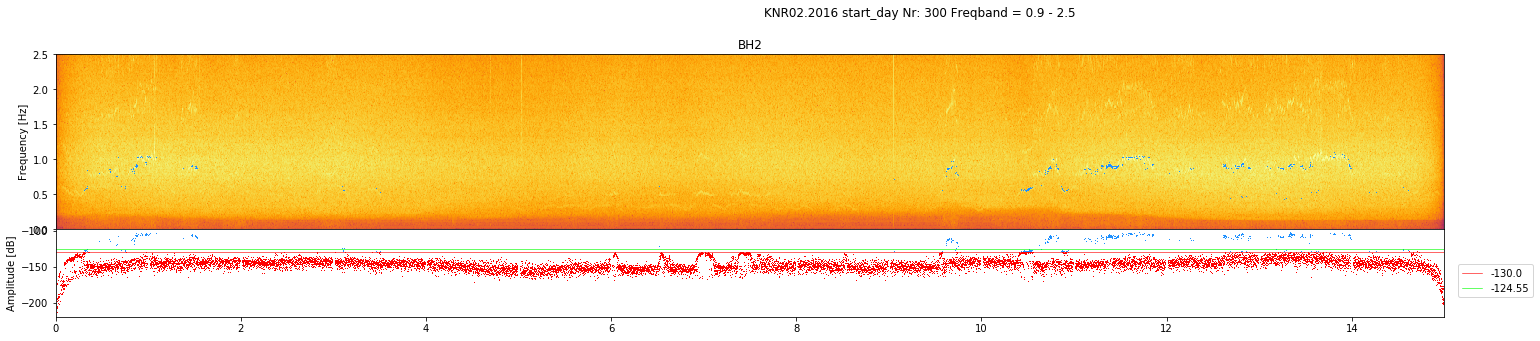

In [9]:
number_bins = 50
#threshold = -13
#threshold = 10**(threshold)
#number_of_days = 6
#print(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
gridsize = (41, 9)
fig = plt.figure(figsize=(32, 22))
fig.subplots_adjust(hspace=0, wspace=0)
#fig.suptitle(station + '.' + 'starttime: ' +  first_date)
#fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=7, rowspan=6)
#ax2 = plt.subplot2grid(gridsize, (0, 7), colspan=1, rowspan=6, sharey=ax1)
ax3 = plt.subplot2grid(gridsize, (6, 0), colspan=7, rowspan=3)


ax1.pcolormesh(specgram_time/3600/24, specgram_freq, 10*np.log10(specgram_appended_all_comps[0]))
ax1.plot(time_stack/3600/24,fund_freq_value_appended[0,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,fund_freq_value_all_appended[0,:],',', color='dodgerblue')
ax1.set_ylim(0,2.5)
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlim(0,number_of_days)
ax1.title.set_text(components[0])
ax1.set_xticks([]) 



ax3.plot(time_stack/3600/24, 10*np.log10(fund_freq_amplitude_all_muted_appended[0,:]),',', color='red')
#ax3.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[0,:]),',', color='red')
ax3.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_appended[0,:]),',', color='dodgerblue')
ax3.axhline(y=10*np.log10(threshold), color='red', linewidth=.6, label=10*np.log10(threshold))
mean0 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[0,:])))
ax3.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[0,:])), color='lime', lw=.6, label=mean0[0:7])
ax3.set_ylabel('Amplitude [dB]')
ax3.set_xlim(0, number_of_days)
ax3.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)

 

plt.suptitle((station+'.'+year+' start_day Nr: '+startday+' Freqband = ' +str(freq_min_bandpass)+' - '+str(freq_max_bandpass) ), x=.5, y=.91)
plt.show()

In [14]:
1/150

0.006666666666666667

In [ ]:
number_bins = 50
#threshold = -13
#threshold = 10**(threshold)
#number_of_days = 6
#print(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
gridsize = (9, 9)
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(hspace=0, wspace=0)
#fig.suptitle(station + '.' + 'starttime: ' +  first_date)
#fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=8, rowspan=9)
#ax2 = plt.subplot2grid(gridsize, (0, 7), colspan=1, rowspan=6, sharey=ax1)
#ax3 = plt.subplot2grid(gridsize, (6, 0), colspan=7, rowspan=3)

#ax4 = plt.subplot2grid(gridsize, (10, 0), colspan=8, rowspan=9, sharex=ax1, sharey=ax1)
#ax5 = plt.subplot2grid(gridsize, (10, 7), colspan=1, rowspan=6, sharey=ax4, sharex=ax2)
#ax6 = plt.subplot2grid(gridsize, (16, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)

#ax7 = plt.subplot2grid(gridsize, (20, 0), colspan=8, rowspan=9, sharex=ax1, sharey=ax1)
#ax8 = plt.subplot2grid(gridsize, (20, 7), colspan=1, rowspan=6, sharey=ax7, sharex=ax2)
#ax9 = plt.subplot2grid(gridsize, (26, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)

#ax10 = plt.subplot2grid(gridsize, (30, 0), colspan=8, rowspan=9, sharex=ax1, sharey=ax1)
#ax11 = plt.subplot2grid(gridsize, (30, 7), colspan=1, rowspan=6, sharey=ax7, sharex=ax2)
#ax12 = plt.subplot2grid(gridsize, (36, 0), colspan=7, rowspan=3, sharex=ax3, sharey=ax3)


ax1.pcolormesh(specgram_time/3600/24, specgram_freq, 10*np.log10(specgram_appended_all_comps[0]))
#ax1.plot(time_stack/3600/24,fund_freq_value_appended[0,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,fund_freq_value_all_appended[0,:],',', color='dodgerblue')
ax1.set_ylim(0,1)
ax1.set_ylabel('Frequency [Hz]')
#ax1.set_xlim(0,number_of_days)
ax1.title.set_text(components[0])
#ax1.set_xticks([]) 

#ax4.pcolormesh(specgram_time/3600/24, specgram_freq, 10*np.log10(specgram_appended_all_comps[1,:,:]))
#ax4.plot(time_stack/3600/24,fund_freq_value_appended[1,:],',', color='dodgerblue')
#ax4.set_ylabel('Frequency [Hz]')
#ax4.title.set_text(components[1])
#ax4.set_xticks([]) 

#ax7.pcolormesh(specgram_time/3600/24, specgram_freq, 10*np.log10(specgram_appended_all_comps[2,:,:]))
#ax7.plot(time_stack/3600/24,fund_freq_value_appended[2,:],',', color='dodgerblue')
#ax7.set_ylabel('Frequency [Hz]')
#ax7.title.set_text(components[2])
#ax7.set_xticks([]) 

#ax10.pcolormesh(specgram_time/3600/24, specgram_freq, 10*np.log10(specgram_appended_all_comps[3,:,:]))
#ax10.plot(time_stack/3600/24,fund_freq_value_appended[3,:],',', color='dodgerblue')
#ax10.set_ylabel('Frequency [Hz]')
#ax10.title.set_text(components[3])
#ax10.set_xticks([]) 

plt.suptitle((station+'.'+year+' Day Nr: '+startday), x=.5, y=.96)
plt.show()

In [ ]:
number_bins = 50
#threshold = -13
#threshold = 10**(threshold)
#number_of_days = 2
#print(station + '.' + component + '_' + 'starttime: ' +  str(st_BHZ[0].stats.starttime)[0:19])
gridsize = (8, 9)
fig = plt.figure(figsize=(15, 8))
fig.subplots_adjust(hspace=0, wspace=0)
#fig.suptitle(station + '.' + 'starttime: ' +  first_date)
#fig.suptitle(station + '.' + component + '_' + 'starttime: ' +  str(trace[0].stats.starttime)[0:19])
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=8, rowspan=6)
#ax2 = plt.subplot2grid(gridsize, (0, 7), colspan=1, rowspan=6, sharey=ax1)
ax3 = plt.subplot2grid(gridsize, (6, 0), colspan=8, rowspan=3)


ax1.pcolormesh(time_stack/3600/24, freq, 10*np.log10(specgram_appended_all_comps[2]))
ax1.plot(time_stack/3600/24,fund_freq_value_all_appended[2,:],',', color='maroon')
ax1.plot(time_stack/3600/24,fund_freq_value_appended[2,:],',', color='dodgerblue')
#ax1.plot(time_stack/3600/24,fund_freq_value_all_appended[0,:],',', color='dodgerblue')
ax1.set_ylim(0,3)
ax1.set_ylabel('Frequency [Hz]')
ax1.set_xlim(0,number_of_days)
ax1.title.set_text(components[2])
ax1.set_xticks([]) 

#ax2.hist(fund_freq_value_appended[2,~np.isnan(fund_freq_value_appended[2,:])], bins=number_bins, color='maroon', orientation='horizontal')
#ax2.yaxis.tick_right()
#ax2.yaxis.set_label_position('right')
#ax2.set_ylabel('Frequency [Hz]')
#ax2.xaxis.tick_top()
#ax2.tick_params(axis="x",direction="in", pad=-22)
#ax2.xaxis.set_label_position('top')
#ax2.set_xlabel('Anzahl')

ax3.plot(time_stack/3600/24, 10*np.log10(fund_freq_amplitude_all_muted_appended[2,:]),',', color='red')
#ax3.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_all_appended[0,:]),',', color='red')
ax3.plot(time_stack/3600/24,10*np.log10(fund_freq_amplitude_appended[2,:]),',', color='dodgerblue')
ax3.axhline(y=10*np.log10(threshold), color='red', linewidth=.6, label=10*np.log10(threshold))
mean0 = str(10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[2,:])))
ax3.axhline(y=10*np.log10(np.nanmean(fund_freq_amplitude_all_muted_appended[2,:])), color='lime', lw=.6, label=mean0[0:7])
ax3.set_ylabel('Amplitude [dB]')
ax3.set_xlim(0, number_of_days)
ax3.set_ylim(-160,-110)
ax3.legend(bbox_to_anchor=(1.01, .6), loc=2, borderaxespad=0.)
plt.suptitle((station+'.'+year+' Day Nr: '+startday + ' HPS'), x=.45, y=.95)
plt.show()

In [ ]:
#np.save('/data/cen/u254/Essing/AWI/arrays/fund_freq_value_appended_KNR07_40days', fund_freq_value_appended) 
#np.save('/data/cen/u254/Essing/AWI/arrays/fund_freq_indi_appended_KNR07_40days', fund_freq_indi_appended)
#np.save('/data/cen/u254/Essing/AWI/arrays/fund_freq_amplitude_appended_KNR07_40days', fund_freq_amplitude_appended)
#np.save('/data/cen/u254/Essing/AWI/arrays/fund_freq_amplitude_all_appended_KNR07_40days', fund_freq_amplitude_all_appended)
#np.save('/data/cen/u254/Essing/AWI/arrays/fund_freq_amplitude_all_muted_appended_KNR07_40days', fund_freq_amplitude_all_muted_appended)
#np.save('/data/cen/u254/Essing/AWI/arrays/specgram_appended_all_comps_KNR07_40days', specgram_appended_all_comps)
#np.save('frequency_values_KNR12_40days', frequency_values)
#np.save('/data/cen/u254/Essing/AWI/arrays/time_stack_40_days', time_stack)
#np.save('/data/cen/u254/Essing/AWI/arrays/freq', freq)

In [ ]:
#fund_freq_value_appended = np.load('/data/cen/u254/Essing/AWI/arrays/fund_freq_value_appended_KNR07_40days.npy') 
#fund_freq_indi_appended = np.load('/data/cen/u254/Essing/AWI/arrays/fund_freq_indi_appended_KNR12_40days', fund_freq_indi_appended)
#fund_freq_amplitude_appended = np.load('/data/cen/u254/Essing/AWI/arrays/fund_freq_amplitude_appended_KNR07_40days.npy')
#fund_freq_amplitude_all_appended = np.load('/data/cen/u254/Essing/AWI/arrays/fund_freq_amplitude_all_appended_KNR07_40days.npy')
#fund_freq_amplitude_all_muted_appended = np.load('/data/cen/u254/Essing/AWI/arrays/fund_freq_amplitude_all_muted_appended_KNR07_40days.npy')
#specgram_appended_all_comps = np.load('/data/cen/u254/Essing/AWI/arrays/specgram_appended_all_comps_KNR07_40days.npy')
#np.save('frequency_values_KNR12_40days', frequency_values)
#time_stack = np.load('/data/cen/u254/Essing/AWI/arrays/time_stack_40_days.npy')
#freq = np.load('/data/cen/u254/Essing/AWI/arrays/freq.npy')